# Dynamic Simulation of Models

This notebook example provides a basic demonstration on how to dynamically simulate models.

In [1]:
import mass.example_data

model = mass.example_data.create_example_model("Phosphate_Trafficking")

Set parameter Username


## Creating a Simulation

The `Simulation` object manages all aspects related to simulating one or more model. This includes interfacing with the `RoadRunner` object from the [libRoadRunner](https://libroadrunner.readthedocs.io/en/latest/index.html) package, which is utilized for JIT compilation of the model, integration of model ODEs, and returning simulation output.

In [2]:
from mass import Simulation

### Loading a model

A `Simulation` object is initialized by providing a `MassModel` to be loaded into the underlying `RoadRunner` object. The provided `MassModel` is treated as the `reference_model` of the `Simulation`. 

`RoadRunner` is designed to simulate models in [SBML](http://sbml.org/Main_Page) format. Therefore, models must be SBML compliant to be loaded into the `RoadRunner` instance.

In [3]:
sim = Simulation(reference_model=model, verbose=True)

Successfully loaded MassModel 'Phosphate_Trafficking' into RoadRunner.


The reference `MassModel` is accessed using the `reference_model` attribute.

In [4]:
sim.reference_model

Name,Phosphate_Trafficking
Memory address,0x07ff318384550
Stoichiometric Matrix,5x6
Matrix Rank,4
Number of metabolites,5
Initial conditions defined,5/5
Number of reactions,6
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


The underlying `RoadRunner` instance can be accessed using the `roadrunner` attribute:

In [5]:
sim.roadrunner

<roadrunner.RoadRunner() { this = 0x600000367fa0 }>

Upon loading a model into a `Simulation`, the numerical values for species' initial conditions and reaction parameters are extracted. Dictionaries containing values are retrieved using the `get_model_simulation_values()` method.

In [6]:
initial_conditions, parameters = sim.get_model_simulation_values(model)
for metabolite, initial_condition in initial_conditions.items():
    print("{0}: {1}".format(metabolite, initial_condition))

adp_c: 0.2
atp_c: 1.7
amp_c: 0.2
B: 2
BP: 8


## Running Dynamic Simulations
### Simulating a model

Once a model has been loaded, it can be simulated using the `Simulation.simulate()` method. The `simulate()` method requires a model identifier or `MassModel` object of a loaded model and a tuple that contains the initial and final time points.

In [7]:
# Simulate the model from 0 to 100 time units
solutions = sim.simulate(model, time=(0, 100))
solutions

(<MassSolution Phosphate_Trafficking_ConcSols at 0x7ff318aed9f0>,
 <MassSolution Phosphate_Trafficking_FluxSols at 0x7ff3593bcc20>)

After a model has been simulated, the concentration and flux solutions are returned in two specialized dictionaries known as `MassSolution` objects. 

In [8]:
conc_sol, flux_sol = solutions

# List the first 5 points of concentration solutions
for metabolite, solution in conc_sol.items():
    print("{0}: {1}".format(metabolite, solution[:5]))

adp_c: [0.2        0.20020374 0.20040726 0.20095514 0.2015016 ]
atp_c: [1.7        1.69982168 1.69964357 1.69916416 1.69868608]
amp_c: [0.2        0.19997458 0.19994916 0.19988069 0.1998123 ]
B: [2.         1.99984758 1.99969535 1.99928569 1.99887727]
BP: [8.         8.00015242 8.00030465 8.00071431 8.00112273]


By default, solutions are returned as `numpy.ndarrays`. To return interpolating functions instead, the `interpolate` argument is set as `True`.

In [9]:
conc_sol, flux_sol = sim.simulate(model, time=(0, 100), interpolate=True)

for metabolite, solution in conc_sol.items():
    print("{0}: {1}".format(metabolite, solution))

adp_c: <scipy.interpolate.interpolate.interp1d object at 0x7ff318af5f90>
atp_c: <scipy.interpolate.interpolate.interp1d object at 0x7ff3593a9ae0>
amp_c: <scipy.interpolate.interpolate.interp1d object at 0x7ff318add950>
B: <scipy.interpolate.interpolate.interp1d object at 0x7ff39988f5e0>
BP: <scipy.interpolate.interpolate.interp1d object at 0x7ff338c82a40>


### Setting integration options

Although the integrator options are set to accomadate a variety of models, there are circumestances in which the integrator options need to be changed. The underlying integrator can be accessed using the `integrator` property:

In [10]:
print(sim.integrator)

< roadrunner.Integrator() >
  name: cvode
  settings:
      relative_tolerance: 1e-06
      absolute_tolerance: 1e-12
                   stiff: true
       maximum_bdf_order: 5
     maximum_adams_order: 12
       maximum_num_steps: 20000
       maximum_time_step: 0
       minimum_time_step: 0
       initial_time_step: 0
          multiple_steps: false
      variable_step_size: true
         max_output_rows: 100000



Each setting comes with a brief description that can be viewed:

In [11]:
print(sim.integrator.getDescription("variable_step_size"))

(bool) Enabling this setting will allow the integrator to adapt the size of each time step. This will result in a non-uniform time column.  The number of steps or points will be ignored, and the max number of output rows will be used instead.


For example, to change the integration options so a uniform time vector is returned instead of one with a variable step size:

In [12]:
sim.integrator.variable_step_size = False

# Simulate the model from 0 to 100 time units
# with output returned at evenly spaced time points
conc_sol, flux_sol = sim.simulate(model, time=(0, 100))

# Print the time vector
print(conc_sol.time[:10])

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]


When encountering exceptions from the integrator, [libRoadRunner recommends](https://libroadrunner.readthedocs.io/en/latest/simulation_and_integration.html) specifying an initial time step and tighter absolute and relative tolerances.

See the [libRoadRunner documentation](https://libroadrunner.readthedocs.io/en/latest/PythonAPIReference/cls_Integrator.html) about the `roadrunner.Integrator` class for more information on the integrator.

### Simulation results and the MassSolution object
For every model simulated, two `MassSolution` objects are returned per model. `MassSolution` objects are always outputted as pairs, with one `MassSolution` object containing the solutions for metabolite concentrations, and the other containing the solutions for reaction fluxes.

In [13]:
# Simulate the model from 0 to 100 time units
sim = Simulation(model)
conc_sol, flux_sol = sim.simulate(model, time=(0, 100))

A `MassSolution` for a successful simulation contains string identifiers of objects and their corresponding solutions. Because `MassSolution` objects are specialized dictionaries, solutions can be retrieved using the object identifier as `dict` keys. For example, to access the solution for "atp_c":

In [14]:
# Print first 10 solution values for ATP
conc_sol["atp_c"][:10]

array([1.7       , 1.69982168, 1.69964357, 1.69916416, 1.69868608,
       1.69820944, 1.69773427, 1.69673394, 1.69460788, 1.6925119 ])

If care is taken when assigning object identifiers (e.g., does not start with a number, does not contain certain characters such as “-”), it is possible to access solutions inside of a `MassSolution` as if the corresponding keys were attributes.

In [15]:
# Print first 10 solution values for ATP
conc_sol.atp_c[:10]

array([1.7       , 1.69982168, 1.69964357, 1.69916416, 1.69868608,
       1.69820944, 1.69773427, 1.69673394, 1.69460788, 1.6925119 ])

The time points returned by the integrator are accessible using the `MassSolution.time` attribute:

In [16]:
# Print the first 10 time points
print(conc_sol.time[0:10])

[0.00000000e+00 8.47847116e-08 1.69569423e-07 3.98257356e-07
 6.26945288e-07 8.55633221e-07 1.08432115e-06 1.56811392e-06
 2.60709564e-06 3.64607737e-06]


The solutions contained within the `MassSolution` can be obtained as a `pandas.DataFrame` using the `to_frame()` method.

In [17]:
conc_sol.to_frame()

,adp_c,atp_c,amp_c,B,BP
Time,,,,,
0.000000e+00,0.200000,1.700000,0.200000,2.000000,8.000000
8.478471e-08,0.200204,1.699822,0.199975,1.999848,8.000152
1.695694e-07,0.200407,1.699644,0.199949,1.999695,8.000305
3.982574e-07,0.200955,1.699164,0.199881,1.999286,8.000714
6.269453e-07,0.201502,1.698686,0.199812,1.998877,8.001123
...,...,...,...,...,...
3.012599e+01,0.399998,1.599991,0.099999,2.000000,8.000000
3.828512e+01,0.399998,1.599992,0.100000,2.000000,8.000000
5.517474e+01,0.399998,1.599994,0.100000,2.000000,8.000000


Solutions also can be viewed visually using the `view_time_profile()` method. Note that this requires `matplotlib` to be installed in the environment. See [Plotting and Visualization](./plot_visualization.ipynb) for more information.

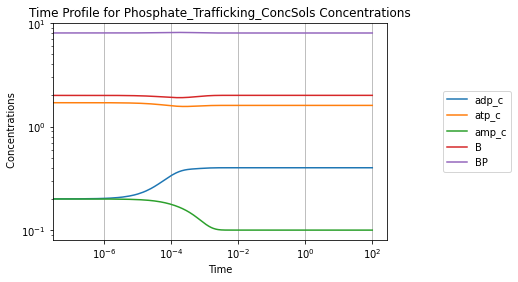

In [18]:
conc_sol.view_time_profile()

### Aggregate variables and solutions

Often, it is desirable to look at mathematical combinations of metabolites concentrations or reaction fluxes. To create an aggregate variable, the `MassSolution.make_aggregate_solution()` method is used. To use the method, three inputs are required:

1. A unique ID for the aggregate variable.
2. The mathematical equation for the aggregate variable given as a `str`.
3. A list of the `MassSolution` keys representing variables used in the equation.

For example, to make the Adenylate Energy Charge <cite data-cite="Atk68">(Atkinson, 1968)</cite>, the occupancy and capacity pools are first defined:

In [19]:
occupancy = conc_sol.make_aggregate_solution(
    aggregate_id="occupancy",
    equation="(atp_c + 0.5 * adp_c)",
    variables=["atp_c", "adp_c"])
conc_sol.update(occupancy)
print(list(conc_sol.keys()))

['adp_c', 'atp_c', 'amp_c', 'B', 'BP', 'occupancy']


The aggregate variables are returned as a `dict`, which can be added to the `MassSolution` object. Alternatively, the `update` flag can be set as `True` to automatically add an aggregate variable to the solution after creation.

In [20]:
capacity = conc_sol.make_aggregate_solution(
    aggregate_id="capacity",
    equation="(atp_c + adp_c + amp_c)",
    variables=["atp_c", "adp_c", "amp_c"], 
    update=True)
print(list(conc_sol.keys()))

['adp_c', 'atp_c', 'amp_c', 'B', 'BP', 'occupancy', 'capacity']


Aggregate variables formed from other aggregate variables also can be created using the `make_aggregate_solution()` method as long as the aggregate variables have been added to the `MassSolution`. To make the energy charge from the occupancy and capacity aggregate variables:

In [21]:
ec = conc_sol.make_aggregate_solution(
    aggregate_id="energy_charge",
    equation="occupancy / capacity",
    variables=["occupancy", "capacity"],
    update=True)

If care is taken when assigning aggregate variable identifiers, it is possible to access aggregate variable solutions inside of a `MassSolution`, as if aggregate variable keys were attributes.

In [22]:
# Print first 10 solution points for the energy charge
conc_sol.energy_charge[:10]

array([0.85714286, 0.85710645, 0.8570701 , 0.85697226, 0.85687471,
       0.85677749, 0.85668059, 0.85647669, 0.85604374, 0.85561747])

## Perturbing a Model

To simulate various disturbances in the system, the `perturbations` argument of the `simulate()` method can be used. There are several types of perturbations that can be implemented for a given simulation as long as they adhere to the following guidelines:

1. Perturbations are provided to the method as a `dict` with dictionary keys that correspond to variables to be changed. Dictionary values are the new numerical values or mathematical expressions as strings that indicate how the value is to be changed.

2. A formula for the perturbation can be provided as a `str` as long as the formula string can be sympified via the `sympy.sympify()` function. The formula can have one variable that is identical to the corresponding `dict` key.

3. Boundary conditions can be set as a function of time. The above rules still apply, but allow for the time "t", as a second variable.

Some examples are demonstrated below.

A simulation without perturbations:

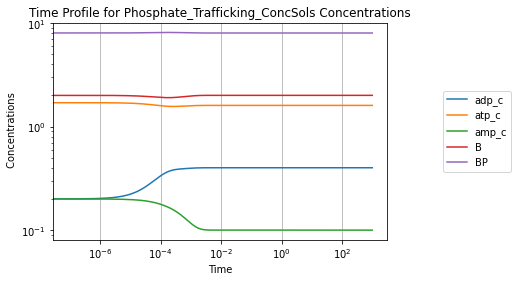

In [23]:
conc_sol, flux_sol = sim.simulate(model, time=(0, 1000))
conc_sol.view_time_profile()

Perturbing the initial concentration of ATP from 1.6 to 2.5:

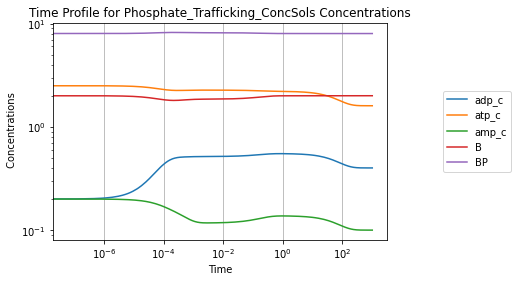

In [24]:
conc_sol, flux_sol = sim.simulate(
    model, time=(0, 1000), perturbations={"atp_c": 2.5})
conc_sol.view_time_profile()

Increasing the rate constant of ATP use by 50%:

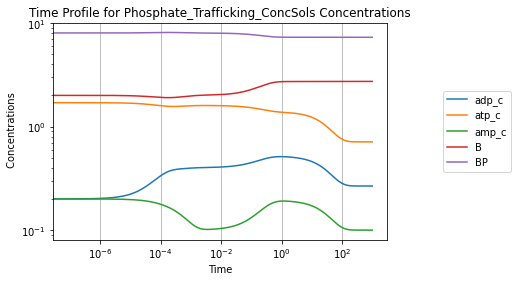

In [25]:
conc_sol, flux_sol = sim.simulate(
    model, time=(0, 1000), perturbations={"kf_use": "kf_use * 1.5"})
conc_sol.view_time_profile()

## Determining Steady State
The steady state for models can be found using the `Simulation.find_steady_state()` method. This method requires a model identifier or a `MassModel` object and a string thats indicates a strategy for finding the steady state. For example, to find the steady state by simulating the model for a long time:

In [26]:
sim = Simulation(reference_model=model)

conc_sol, flux_sol = sim.find_steady_state(model, strategy="simulate")
for metabolite, solution in conc_sol.items():
    print("{0}: {1}".format(metabolite, solution))

adp_c: 0.3999999999999983
atp_c: 1.5999999999999932
amp_c: 0.09999999999999959
B: 1.999999999999997
BP: 7.999999999999988


Alternatively, a steady state solver can be utilized with a root-finding algorithm to determine the steady state. For example, to use a non-linear equation solver that implements a global Newton method with adaptive damping strategies ([NLEQ2](http://elib.zib.de/pub/elib/codelib/NewtonLib/)) or a line-search method:

In [27]:
conc_sol, flux_sol = sim.find_steady_state(model, strategy="newton_linesearch")
for metabolite, solution in conc_sol.items():
    print("{0}: {1}".format(metabolite, solution))

adp_c: 0.39999920693137425
atp_c: 1.599996808967697
amp_c: 0.09999980294303153
B: 2.0000000187666185
BP: 7.999999981233392


Setting `update_values=True` updates the model initial conditions and fluxes with the steady state solution:

In [28]:
conc_sol, flux_sol = sim.find_steady_state(model, strategy="newton_linesearch",
                                           update_values=True)
model.initial_conditions  # Same object as reference model in Simulation

{<MassMetabolite adp_c at 0x7ff35937a250>: 0.39999920693137425,
 <MassMetabolite atp_c at 0x7ff35937a280>: 1.599996808967697,
 <MassMetabolite amp_c at 0x7ff35937a310>: 0.09999980294303153,
 <MassMetabolite B at 0x7ff35937a340>: 2.0000000187666185,
 <MassMetabolite BP at 0x7ff35937a370>: 7.999999981233392}

The `find_steady_state()` method also allows for perturbations to be made before determining a steady state solution:

In [29]:
conc_sol, flux_sol = sim.find_steady_state(
    model, strategy="simulate", perturbations={"kf_use": "kf_use * 1.5"})

for metabolite, solution in conc_sol.items():
    print("{0}: {1}".format(metabolite, solution))

adp_c: 0.26666666666666217
atp_c: 0.7111111111110989
amp_c: 0.09999999999999833
B: 2.72727272727273
BP: 7.272727272727279


### The steady state solver

Although the steady state solver options are set to accommodate a variety of models, there are circumstances in which the steady state solver options need to be changed. The underlying solver can be accessed using the `steady_state_solver` property:

In [30]:
print(sim.steady_state_solver)

< roadrunner.SteadyStateSolver() >
  name: newton_linesearch
  settings:
    auto_moiety_analysis: false
     allow_presimulation: true
      presimulation_time: 5
     presimulation_times: [0.1, 1, 10, 100, 1000, 10000]
    presimulation_maximum_steps: 500
            allow_approx: true
        approx_tolerance: 1e-06
    approx_maximum_steps: 10000
             approx_time: 10000
           num_max_iters: 200
          allow_negative: false
             print_level: 0
                eta_form: 'eta_choice1'
           no_init_setup: false
       no_res_monitoring: false
         max_setup_calls: 10
      max_subsetup_calls: 5
      eta_constant_value: 0.1
         eta_param_gamma: 0
         eta_param_alpha: 0
             res_mon_min: 1e-05
             res_mon_max: 0.9
    res_mon_constant_value: 0.9
              no_min_eps: false
         max_newton_step: 0
          max_beta_fails: 10
           func_norm_tol: 0
         scaled_step_tol: 0
            rel_err_func: 0



Analogous to the integrator, each setting for the steady state solver comes with a brief description that can be viewed:

In [31]:
print(sim.steady_state_solver.getHint("approx_maximum_steps"))

Maximum number of steps that can be taken for steady state approximation routine (int).


For example, to change the solver options to allow for a larger maximum number of iterations:

In [32]:
sim.steady_state_solver.approx_maximum_steps = 15000

For more information on steady state solver options, see the [libRoadRunner documentation](https://libroadrunner.readthedocs.io/en/latest/PythonAPIReference/cls_SteadyStateSolver.html) about the `roadrunner.SteadyStateSolver` class.

## Simulating Multiple Models

Multiple models can be added to a `Simulation` object in order to perform simulations on several models. Below, a simple example utilizing a copy of the model with a smaller total buffer concentration is made for demonstration purposes:

In [33]:
model = mass.example_data.create_example_model("Phosphate_Trafficking")
sim = Simulation(model)

# Make a modified model
modified = model.copy()
modified.id = "Phosphate_Trafficking_Modified"
modified.update_initial_conditions({"BP": 4, "B": 1})

To add an additional model to an existing `Simulation` object, three criteria must be met:

1. The model must have equivalent ODEs to the `reference_model` used in creating the `Simulation`.
2. All models in the `Simulation` must have unique identifiers.
3. Numerical values necessary for simulation must be already defined for a model.

Use the `MassModel.has_equivalent_odes()` method to check if ODEs are equivalent.

In [34]:
sim.reference_model.has_equivalent_odes(modified, verbose=True)

True

Use the `Simulation.add_models()` method to load the additional model.

In [35]:
sim.add_models(models=[modified], verbose=True)

Successfully loaded MassModel 'Phosphate_Trafficking_Modified'.


Use the `simulate()` method to simulate multiple models by providing a list of model objects or their identifiers.

In [36]:
conc_sol_list, flux_sol_list = sim.simulate(
    models=[model, modified], time=(0, 100))

After simulating multiple models, the `MassSolution` objects are returned in two `cobra.DictList` objects. The first `DictList` contains the concentrations solutions, and the second `DictList` contains the flux solutions for simulated models.

In [37]:
conc_sol_list

[<MassSolution Phosphate_Trafficking_ConcSols at 0x7ff388fe1b80>,
 <MassSolution Phosphate_Trafficking_Modified_ConcSols at 0x7ff328e0b590>]

The `get_by_id()` method can be used to access a specific solution:

In [38]:
conc_sol_list.get_by_id("_".join((modified.id, "ConcSols")))

<MassSolution Phosphate_Trafficking_Modified_ConcSols at 0x7ff328e0b590>

For additional information on simulating multiple models, see [Simulating an Ensemble of Models](./ensemble_modeling.ipynb#Simulating-an-Ensemble-of-Models).